# Example of upper limit computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import pltdist, plotfitresult, plotlimit

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import FrequentistCalculator
from hepstats.hypotests import UpperLimit
from hepstats.hypotests.parameters import POI, POIarray

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit-0.0.0-py3.7.egg/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 16

### Fit of a Gaussian signal over an exponential background:

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

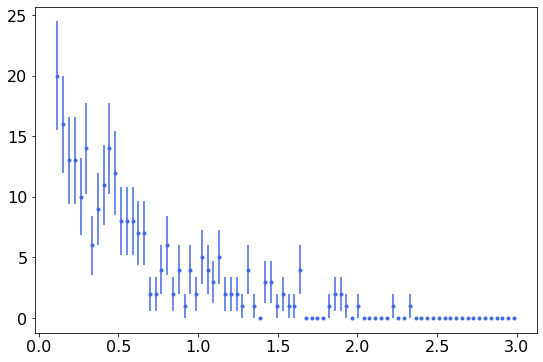

In [4]:
pltdist(data, bins=80, bounds=bounds)

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 1., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [7]:
signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [8]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_) 

In [9]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [10]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse()
print(minimum)

------------------------------------------------------------------
| FCN = -1077                   |      Ncalls=66 (66 total)      |
| EDM = 4.88E-05 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_3, Composed_autoparam_4] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f83ba1af9d0>] constraints=[]> 
w

Text(0, 0.5, 'number of events')

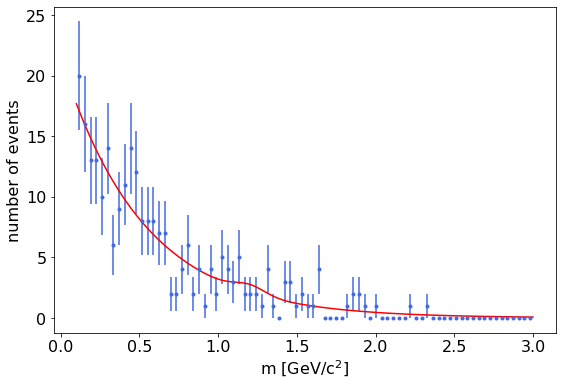

In [11]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Upper limit:

Since the signal yield Nsig = $4.5 \pm 5.8$  is consistent with zero signal we compute the CLs upper limit at 95% confidence level on Nsig.

In [12]:
# instantation of the calculator
calculator = FrequentistCalculator(nll, minimizer, ntoysnull=5000, ntoysalt=5000)
#calculator = FrequentistCalculator.from_yaml("upperlimit_freq_zfit_toys.yml", nll, minimizer, ntoysnull=7500, ntoysalt=10000)
calculator.bestfit = minimum #optionnal

In [13]:
# parameter of interest of the null hypothesis
poinull = POIarray(Nsig, np.linspace(0.0, 25, 15))
# parameter of interest of the alternative hypothesis
poialt = POI(Nsig, 0.)

In [14]:
# instantation of the discovery test
ul = UpperLimit(calculator, poinull, poialt)

In [ ]:
ul.upperlimit(alpha=0.05, CLs=True);

Generating null hypothesis toys for POI('Nsig', value=0.0).
0 toys generated, fitted and scanned!
1000 toys generated, fitted and scanned!
2000 toys generated, fitted and scanned!
3000 toys generated, fitted and scanned!
4000 toys generated, fitted and scanned!


In [ ]:
f = plt.figure(figsize=(9, 8))
plotlimit(poinull.values, ul.pvalues(CLs=True), alpha=0.05, CLs=True)
plt.xlabel("Nsig");

In [ ]:
f = plt.figure(figsize=(9, 8))
ax = plotlimit(poinull.values, ul.pvalues(CLs=False), alpha=0.05, CLs=False)
plt.xlabel("Nsig");

In [ ]:
ul_qtilde = UpperLimit(calculator, poinull, poialt, qtilde=True)

In [ ]:
ul_qtilde.upperlimit(alpha=0.05, CLs=True);

In [ ]:
f = plt.figure(figsize=(9, 8))
plotlimit(poinull.values, ul_qtilde.pvalues(CLs=True), alpha=0.05, CLs=True)
plt.xlabel("Nsig");

In [ ]:
calculator.to_yaml("upperlimit_freq_zfit_toys.yml")